In [1]:
import tensorflow as tf
import numpy as np

# This notebook contains notes on all steps necessary to understand basic Transformer architecture.

## Keras basics
Keras gives simple API to programming neural networks with tensorflow. This section will provide quick overview of most important features used in code. More detailed explanations can be found [here](https://www.tensorflow.org/guide/keras). Important feature (in terms of understanding Keras code) is that Keras doesn't need input shape of NN to be specified, it can be determined during runtime, so usually Input layer is omitted.
### How to create models - Sequential model
Sequential model provides simple way to program neural networks that can be modeled as stack of layers. Example code that models NN with hidden layer of 3 neurons (relu activation) and output of 2 neurons:

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3, activation="relu", name="hidden"),
        tf.keras.layers.Dense(2, name="output"),
    ])

Model created above can be called on input $x$ with shape 3x3 (for example batch_size x n_features)

In [ ]:
x = tf.ones((3, 3))
y = model(x)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (3, 3)                    12        
                                                                 
 output (Dense)              (3, 2)                    8         
                                                                 
Total params: 20 (80.00 Byte)
Trainable params: 20 (80.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




Another way to create such model is to create and add layers separately.

In [ ]:
model = tf.keras.Sequential()
hidden = tf.keras.layers.Dense(3, activation="relu", name="hidden")
model.add(hidden)
out = tf.keras.layers.Dense(2, name="output")
model.add(out)


x = tf.ones((3, 3))
y = model(x)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (3, 3)                    12        
                                                                 
 output (Dense)              (3, 2)                    8         
                                                                 
Total params: 20 (80.00 Byte)
Trainable params: 20 (80.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### How to create models - Functional API
Functional API enables creation of more complicated models - ones that cannot be modeled as stack of layers (for example ones that take more than one input). Let's create model that takes 10-dimensional vector as input, feeds it into dense layer with 4 neurons and outputs 1 neuron. Here we create layers separately and link them using call operator. Since here input is defined explicitly, we can show summary before feeding real data to model - that's why layer output shapes have None - to accommodate batch size. 

In [ ]:
inputs = tf.keras.Input(shape=(10,), name="inputs")
hidden = tf.keras.layers.Dense(4, activation="relu", name="hidden")(inputs)
out = tf.keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 hidden (Dense)              (None, 4)                 44        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### How to train models
To train model, first it needs to be compiled. We can specify optimizer used and cost function.

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

Then we can fit model. Train data, validation data, batch size and number of epochs can be specified. Train data can be either passed as x_train and y_train or as tf.dataset

In [ ]:
# prepare data
x_train = tf.ones((10, 10))
y_train = tf.ones((10, 1))
x_val = tf.ones((1, 10))
y_val = tf.ones((1, 1))

print("fit by passing x_train, y_train")
model.fit(x_train, y_train, batch_size=2,  epochs=1, validation_data=(x_val, y_val))

print("fit with dataset")
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
model.fit(dataset, epochs=1)

fit by passing x_train, y_train
5/5 [==============================] - 1s 63ms/step - loss: 1.6733 - val_loss: 1.6168
fit with dataset
5/5 [==============================] - 0s 3ms/step - loss: 1.5804


## Dense NNs vs RNNs
Note: biases are omitted in all calculations and pictures to simplify a little bit

### Simplest case - Dense Neural Network
The simplest NN is a dense one - it takes some inputs $x$, has some hidden neurons $h$ and produces some output $y$. It has 2 sets of weights:
- $W_{xh}$ that are applied to input
- $W_{hy}$ that are applied to hidden state before producing output
  
Picture below portraits dense neural network with one hidden layer

![Simple NN](./images/obraz_2023-07-31_194835707.png)

Or, in simplified form it can be pictured as:

![Simplified NN picture](./images/obraz_2023-07-31_195230251.png)

During forward pass such neural network does following computations:
1) compute hidden activations $h = tanh(x \cdot W_{xh})$*
2) produce output $ y = h \cdot W_{hy}$
   
\* tanh is used as activation function, but it can be anything (relu/sigmoid)

In dense NNs hidden layer can have different shape than input. If for example we have 10-dimensional input, 4 hidden neurons and 1 output, shapes of NN components are:
- $x$ = (n_batches, 10) - input
- $W_{xh}$ = (10, 4)
- $h$ = (n_batches, 4) - hidden layer output
- $W_{hy}$ = (4, 1)
- $y$ = (n_batches, 1) - output

Below is example code that defines such network
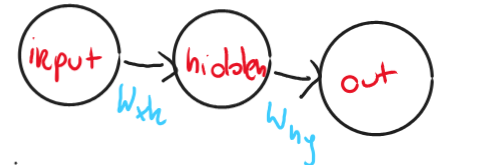
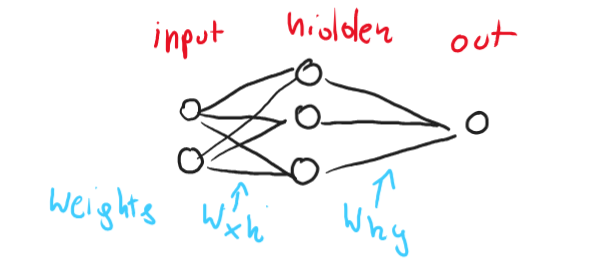

In [ ]:
inputs = tf.keras.Input(shape=(10,), name="inputs")
hidden = tf.keras.layers.Dense(4, activation="relu", name="hidden")(inputs)
out = tf.keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10)]              0         
                                                                 
 hidden (Dense)              (None, 4)                 44        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To apply dense NNs for time series prediction, first data needs to be properly prepared due to the fact, that dense NNs take input of fixed size. If for example we have 14 data points and we want to predict 1 timestamp ahead based on 10 previous timestamps, 3 training samples would be generated from our dataset.

In [ ]:
import numpy as np
window_size = 10

raw_data = np.random.rand(14)
dataset = np.lib.stride_tricks.sliding_window_view(raw_data[:-1], (window_size + 1, ))
x = dataset[:, :-1]
y = dataset[:, -1]
print(f'X shape: {x.shape}, Y shape: {y.shape}. Got {y.shape[0]} batches')

X shape: (3, 10), Y shape: (3,). Got 3 batches


### Recurrent Neural Networks
Most basic RNN can be defined as series of cells, where each cell takes input $x$, returns output $y$ and in each time step passes hidden state $h$ to next time step. This neural network architecture includes 3 sets of weights: 
- $W_{hh}$ that are applied to hidden state passed from previous timestep
- $W_{xh}$ that are applied to input at each timestep
- $W_{hy}$ that are applied to hidden state before producing output at each timestep


Below picture shows whole architecture in a compact way.

![Compact picture of RNN](./images/obraz_2023-07-31_195840738.png)

One of the most important concepts in RNNs is unrolling - that means picturing network cells for different timestamps as separate neurons. Below picture shows network presented above unrolled for 3 timesteps.

![Unrolled picture of RNN](./images/obraz_2023-07-31_200503554.png)


Network takes as input initial hidden state -  $h_{start}$, usually initialized to 0.
In timestep $t = 1$ network takes two inputs - $h_0$ (hidden state from previous timestep) and $x_1$ (input at timestep 1), produces two outputs - $h_1$ that is passed to next timestep and $y_1$ that is output for this timestep.

During forward pass at timestep $t$ such neural network does following computations:
1) calculate hidden activations $h_t = tanh(W_{hh} \cdot h_{t - 1} + W_{xh} \cdot x_t )$*
2) produce output $ y_t = h_t \cdot W_{hy}$

\* tanh is used as activation function, but it can be anything (relu/sigmoid)

These steps are calculated at each timestep using the same wieghts. 

Like in dense NNs, hidden layer can have different shape than input. If for example we have 1-D input, 4 hidden units, which implies 4-D output. If we want to get 1-D output dense layer on top of RNN is required. Shapes of whole network (RNN + Dense) components are:

Shapes below are result of setting return_sequences for RNN to False - that means that RNN layer will return only last output

- $x$ = (n_batches, n_timesteps, 1) - input
- $W_{xh}$ = (1, 4)
- $h$ = (1, 4) - hidden layer output - calculated at each step
- $W_{hy}$ = (4, 4)
- $W_{hy}$ = (4, 4)
- $y_{hidden}$ = (n_batches, 4) - output - result of running n_batches through RNN
- $W_{dense}$ = (4,  1) - weights of dense layer
- $y_{dense}$ = (n_batches, 1) - output

If we set return_sequences to True shapes are as follows:

- $x$ = (n_batches, n_timesteps, 1) - input
- $W_{xh}$ = (1, 4)
- $h$ = (1, 4) - hidden layer output - calculated at each step
- $W_{hy}$ = (4, 4)
- $W_{hy}$ = (4, 4)
- $y_{hidden}$ = (n_batches, n_timesteps, 4) - output - result of running n_batches through RNN
- $W_{dense}$ = (4,  1) - weights of dense layer, applied at each timestep
- $y_{dense}$ = (n_batches, n_timesteps, 1) - output


Below is example code that defines such networks
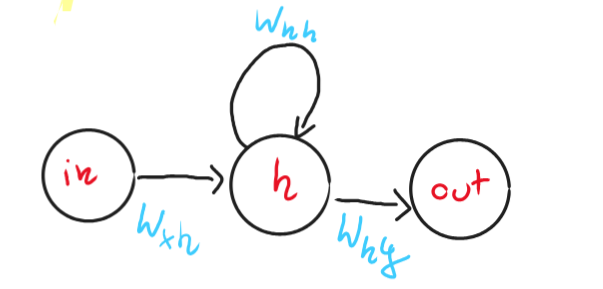
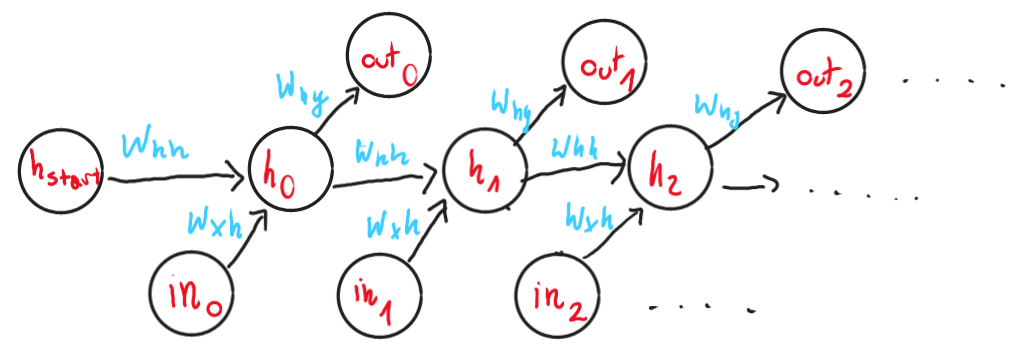

In [ ]:
timesteps = 5
# not returning sequences
inputs = tf.keras.Input(shape=(timesteps, 1), name="inputs")
hidden = tf.keras.layers.SimpleRNN(4, name="hidden", return_sequences=False)(inputs)
out = tf.keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()
# returning sequences
inputs = tf.keras.Input(shape=(timesteps, 1), name="inputs")
hidden = tf.keras.layers.SimpleRNN(4, name="hidden", return_sequences=True)(inputs)
out = tf.keras.layers.Dense(1, activation="linear", name="out")(hidden)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden (SimpleRNN)          (None, 4)                 24        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 29 (116.00 Byte)
Trainable params: 29 (116.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidde

#### Stacking RNNs
RNNs can be stacked to create multiple layers. In such configuration at each timestep output from first RNN is passed as input for another one. In such case all layers that pass outputs to another layer, must return sequences, so each timestep is passed.
If we would want to pass just last output, it would create encoder - decoder architecture, which will be explained later. Below is example architecture definition that stacks RNN layers.

In [ ]:
timesteps = 5
inputs = tf.keras.Input(shape=(timesteps, 1), name="inputs")
hidden1 = tf.keras.layers.SimpleRNN(4, name="hidden1", return_sequences=True)(inputs)
hidden2 = tf.keras.layers.SimpleRNN(5, name="hidden2", return_sequences=True)(hidden1)
hidden3 = tf.keras.layers.SimpleRNN(6, name="hidden3", return_sequences=False)(hidden2)
out = tf.keras.layers.Dense(1, activation="linear", name="out")(hidden3)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden1 (SimpleRNN)         (None, 5, 4)              24        
                                                                 
 hidden2 (SimpleRNN)         (None, 5, 5)              50        
                                                                 
 hidden3 (SimpleRNN)         (None, 6)                 72        
                                                                 
 out (Dense)                 (None, 1)                 7         
                                                                 
Total params: 153 (612.00 Byte)
Trainable params: 153 (612.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## LSTMs
### General concept
Similarly to how simple RNNs, LSTMs are built from cells. Here cell structure is a little more complicated — each cell has 3 inputs and 2 outputs. Outputs of each cell are:
- $c$ - called "state", because it transports data between timesteps, while undergoing little modification at each timestep, which allows for capturing long time dependencies (also called "Long Term Memory")
- $h$ - being output of given cell. It is modified at every step depending on $c$, previous timestep's output and current input, which allows for capturing short time dependencies (also called "Short Term Memory")

Inputs for each cell are $h$ and $c$ from previous cell and $x$ at given timestep.

Having this 2 tensors $h$, $c$ passed between timesteps allows this architecture to learn both long and short term dependecies in data - that's why it's called Long Short Term Memory.

### Cell's internal structure
Each cell has 3 main components:
- forget gate responsible for selecting which elements of state passed from previous timestep will be forgotten and which will be used to produce output and passed to next timestep
- input gate responsible for updating state
- output gate responsible for deciding how state will affect output and producing it

Each component is modeled using neural network and has it's own set of weights.

- Forget gate is single neural network that on given timestep $t$, based on $h_{t-1}$, $x_t$ and weights $w_f$ produces vector $f$. Sigmoid is used as activation function, so $f$ elements $\in <0, 1>$. $f$ is multiplied element-wise with state $c_{t-1}$ - this operation decides which elements of $c_{t-1}$ will be forgotten.
- Input gate consists of 2 neural networks, both taking $h_{t-1}$, $x_t$ as input.
    - First one produces candidate state $C$ based on $W_c$ set of weights. It uses tanh activation function (since $c$ elements $\in <-1; 1>$)
    - Second one is responsible for deciding how candidate state $C$ will affect state $c$ passed to next step and used to produce output. Based on weights $W_i$ it produces tensor $i$, which elements $\in <0; 1>$ because sigmoid activation is used.
    - Outputs of these networks are multiplied with each other element-wise and then added to $c_{t-1} \cdot f$ (produced by forget gate) in order to produce state $c_t$. 
- Output gate consists of single neural network, with sigmoid activation, which decides how state $c_t$ will affect output $h_t$. Based on weights $w_o$ it produces $o$ vector, which is multilpied element-wise with $tanh(c_t)$ in order to produce output $h_t$. $tanh$ is used here to squeeze $c$ to $<-1; 1>$.

Picture below ilustrates in greater detail how LSTM cell works.
![LSTM cell](./images/obraz_2023-08-02_200510371.png)
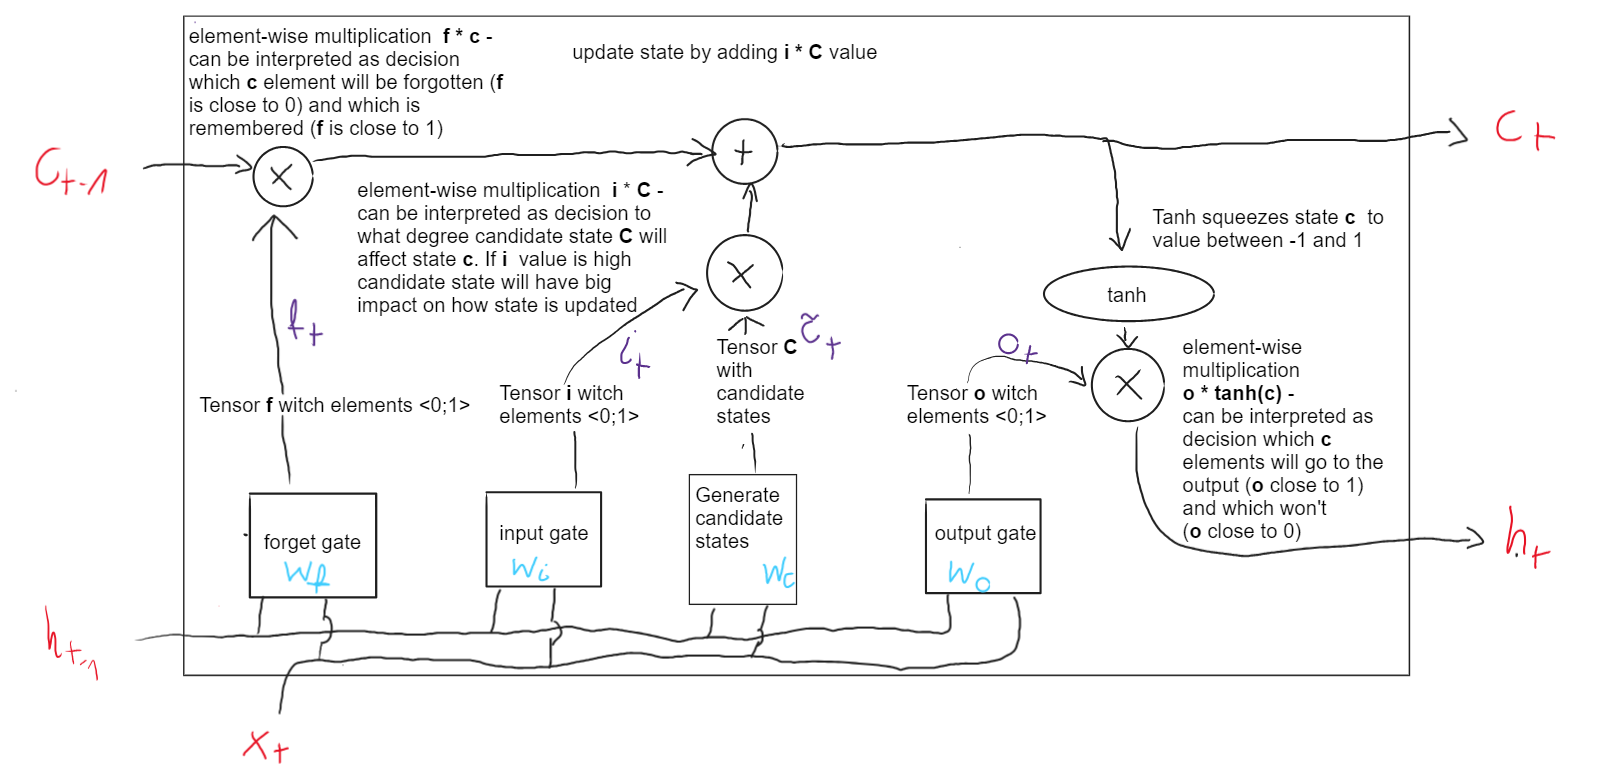

### What computations are done in every cell
1) $f_t = sigmoid(w_f \cdot [h_{t-1}, x_t])$
2) $c_t = c_{t-1} \cdot f_t$
3) $C_t = tanh(w_c \cdot [h_{t-1}, x_t])$
4) $i_t = sigmoid(w_i \cdot [h_{t-1}, x_t])$
5) $c_t$ += $i_t \cdot C_t$
6) $o_t = sigmoid(w_o \cdot [h_{t-1}, x_t])$
7) $h_t = o_t \cdot tanh(c_t)$

### Example
In keras LSTMs are used exactly the same as regular RNNs, so parameter passed as number of units determines dimensionality of $h_t$.

Let's say we want to create a network that based on 1-D data predicts next step in that data. Our network will have 2 stacked LSTMs - one with 10 hidden units, second with 15 units and dense layer to aggregate this data into 1 predicted point in time. We can set return_sequences=True for last LSTM layer, so our model will learn to predict next value at each timestep, which means we can predict sequences of arbitrary length by just feeding previous output as input to next step. Then if our input series is $[1, 2, 3, 4, 5, 6]$ we can set model inputs and outputs to $x = [1, 2, 3, 4, 5]$, $y = [2, 3, 4, 5, 6]$. If we didn't set return_sequences to True we would teach our model to first take $n$ timesteps, then predict.

In [ ]:
timesteps = 5
inputs = tf.keras.Input(shape=(timesteps, 1), name="inputs")
hidden1 = tf.keras.layers.LSTM(10, name="hidden1", return_sequences=True)(inputs)
hidden2 = keras.layers.LSTM(15, name="hidden2", return_sequences=True)(hidden1)
out = tf.keras.layers.Dense(1, activation="linear", name="out")(hidden2)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 1)]            0         
                                                                 
 hidden1 (LSTM)              (None, 5, 10)             480       
                                                                 
 hidden2 (LSTM)              (None, 5, 15)             1560      
                                                                 
 out (Dense)                 (None, 5, 1)              16        
                                                                 
Total params: 2056 (8.03 KB)
Trainable params: 2056 (8.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's take a closer look at weights of first LSTM.
Inputs for it will be shape $(n, 5, 1)$, and cell has 10 units so
LSTM cell at given timestep will take following parameters:

(omitting batch size)
- $h_t = (10)$
- $c_t = (10)$
- $x_t = (1)$
- $w_f = w_i = w_c = w_o =(11, 10) $ - shape of $h_t$ joined with $x_t$ by shape of $c_t$

## Autoencoders
### Architecture
After understanding LSTMs, autoencoders are quite simple architecture. Problem that they solve is creating output of different length than input. With RNNs we can predict multiple timesteps ahead, but it's done by running multiple timesteps with predictions as inputs to next timesteps, but we can't explicitly teach the model to predict $n$ timesteps ahead. The main idea behind autoencoders it to create 2 separate networks : 
- encoder, that encodes the data into context vector,that contains all the information necessary to make predictions
- decoder, that based on context vector produces final predictions

When it comes to time series processing, basic encoder-decoder setups use RNNs (or their variations like LSTMs) as building blocks for both parts of the architecture. Context vector is usually final hidden state of encoder, with which decoder hidden state is initialized.

Encoder-decoder architecture is derived from seq2seq problems like translation, where during training decoder input at timestamp $t$ is set to correct translated value of previous timestep $y_{t-1}$ - setting inputs to decoder in such way is called teacher forcing. In time series prediction tasks, teacher forcing isn't ideal way to teach decoder, since usually time series value at $t$ is highly correlated with value at $t-1$, so decoder learns to make predictions based on previous value (which during inference will be predicted value of previous timestep, not true one) instead of context vector. This leaves us with 2 possible ways of setting decoder inputs during training - either to 0 or to elements of context vector.

Picture below portraits high-level architecture of encoder-decoder setup

![encoder decoder architecture](./images/obraz_2023-08-02_213214447.png)

### Example
In this example we will define encoder-decoder architecture with 10-unit LSTMs as both encoder and decoder. Such setup can predict arbitrary number of timesteps ahead based on arbitraty number of input timesteps. Nubmer of input and output timesteps will be defined by dataset on which it will be trained. Here input timesteps number will be set to 5 in order to better ilustrate layer output dimensions and output timesteps will be set to 2, to simplify code (for arbitrary number of outputs custom layer would need to be defined, here we'll just use RepeatVector to serve as decoder inputs at each timestep).
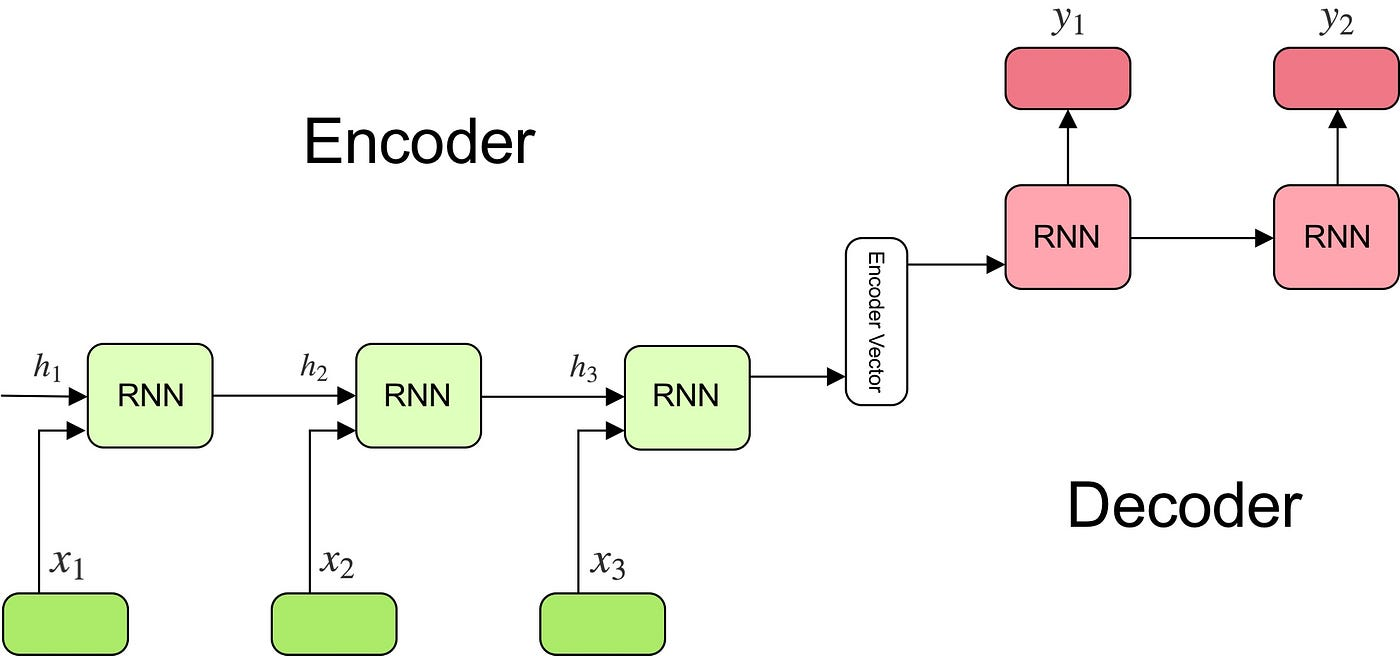

In [ ]:
input_timesteps = 5
output_timesteps = 2
batch_size = 1

encoder_inputs =  tf.keras.layers.Input(shape=(input_timesteps, 1))
encoder = tf.keras.layers.LSTM(10, return_state=True, return_sequences=False)
# state_h and state_c are context vector
# encoder_outputs are discarded (they are the same as state_h since LSTM is used)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# using hidden state h from encoder as inputs at each decoder timestep
# decoder =  tf.keras.layers.RepeatVector(output_timesteps)(state_h)
# using zeros as inputs at each decoder timestep
decoder =  tf.keras.layers.RepeatVector(output_timesteps)(tf.zeros((batch_size, 1)))

decoder_lstm =  tf.keras.layers.LSTM(10, return_sequences=True, return_state=False)
decoder = decoder_lstm(decoder, initial_state=[state_h, state_c])

# using dense layer to aggregate 10-D LSTM output
# using TimeDistributed to make it clear that dense layer is applied to every timestep separately
# but it does not make any real difference (i believe)
out =  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder)
model =  tf.keras.models.Model(encoder_inputs, out)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 10),                 480       ['input_1[0][0]']             
                              (None, 10),                                                         
                              (None, 10)]                                                         
                                                                                                  
 lstm_1 (LSTM)               (1, 2, 10)                   480       ['lstm[0][1]',                
                                                                     'lstm[0][2]']          

## Attention
### General idea
Attention is somewhat complicated way to express a simple idea - having vector $x$ and $y$ we would want to calculate how diffenent elements of $x$ influence different elements of $y$ (so in other words we want to assign different weight to each element of $x$ depending on how much it influences each element of $y$). Let's put our weights in vector $a$ of size $size(x)$ x $size(y)$, so for each element of $x$ each element of $y$ has some weight Now let's write it down mathematically.

$a_{i, j} = attention(x_i, y_j)$, where $attention$ is function telling us how similar it's arguments are.

The simplest way of telling how similar two numbers are is multiplying them, so in the simplest case $a$ could be calculated as a dot product of $x$ and $y$.

$a = x \cdot y $

*Note: attention function can be also more complicated - for example modeled by neural network. Attention computed as dot product is called "Luong attention"*


We would also like $a$ to have nice property of being probability distribution, so it would tell us with what probability each element of $x$ has a high influence on each element of $y$. This can be achieved by running $a$ through a softmax function.

$p = softmax(a) \Leftrightarrow p_{i, j} = \frac{exp(a_{i, j})}{\sum_k exp(a_{i, k})}$

$p$ that we calculated is called attention scores and tells us what's the relationship between elements of $x$ anf $y$ - i.e. if $p_{ij}$ is close to 1, that means the relationship between $x_i$ and $y_j$ is strong.

### But why is it called attention ?
Calling it attention originates from where the concept is used. It was developed as a way to give decoder (in encoder-decoder architecture discussed earlier) a way to have access to all hidden states of encoder instead of just final one passed as context vector. If at each step of decoder we calculate attention score between it's state at this timestep and all encoder hidden states we can get information on which timesteps of encoder have the most influence on prediction that should be produced by decoder - in other words we get information to which encoder states decoder should pay the most ***attention***.


### Queries and Values notation
Attention inputs can also be called queries and values, since calculating attention is analogous to operation of calculating match score between set of queries (i.e. to the database) and set of values (i.e. possible search results stored in this database. Conceptually, it can be visualized as how Google works. 
Let's say that Google has database of 3 websites: $v_1 = $"www.motocycles.com",  $v_2 = $ "www.cars.com", $v_3 = $ "www.airplanes.com" and at given moment receives 2 queries: $q_1 = $"What's best engine?", $q_2 = $"Is Ford good car?".

For $q_1$ attention scores would be relatively similar for all values since all of the motorcycles, cars and airplanes have engines, but for $q_2$, $v_2 = $ "www.cars.com" would definitely have the highest score, so our attention scores might look like:

| $v_1$| $v_2$| $v_3$|
| ---  | ---  | ---  |
| 0.33 | 0.33 | 0.34 |
| 0.01 | 0.98 | 0.01 |  


### Attention layer
As explained earlier, we would want to give decoder access to all previous states of encoder along with ability to pay attention only to subsection of it, that is the most important at given step. In order to do that, attention layer needs to be created. Attention layer is implementation of concept described in previous paragraph - it takes query and value, then calculates attention scores between them. Then it multiplies attention by values vector, producing a matrix where for each query element it's corresponding attention vector contains value elements scaled by attention scores. If attention layer decided to pay low attention to given element$^{\bf*}$, it will be scaled down, otherwise it will remain close to it's original value.

$^{\bf*}$element from values vector

***calculating attention_layer(query, value):***

$raw\_attention\_scores = attention(query, value)$

let's use simple attention function:

$raw\_attention\_scores = query \cdot value$

$attention\_scores\_distribution = softmax(raw\_attention\_scores)$

$attention\_output = attention\_scores\_distribution \cdot value$


### Addinig attention to encoder-decoder
There are multiple ways to incorporate attention layer into encoder-decoder architecture.
- One of them is to at each timestep $t$ of decoder calculate attention values between decoder state at previous timestep and encoder hidden states  - $attention(decoder\_hidden\_state_{t-1}, encoder\_hidden\_states)$ and pass attention vlaues combined with $decoder\_hidden\_state_{t-1}$ to next decoder timestep
- Another one is to leave decoder as is, but add additional layer on top of it that will take decoder output and attention values as input, producing final prediction. This approach is implemented below. 

It extends basic LSTM network architecture by adding attention layer with encoder outputs being values and decoder outputs being queries. Then attention vector (being encoder outputs scaled by attention) along with decoder outputs are passed through dense network in order to create a prediction. 

In [ ]:
input_timesteps = 5
output_timesteps = 2
batch_size = 1

encoder_inputs =  tf.keras.layers.Input(shape=(input_timesteps, 1))
encoder = tf.keras.layers.LSTM(10, return_state=True, return_sequences=False, name="encoder")
# state_h and state_c are context vector
# encoder_outputs are discarded (they are the same as state_h since LSTM is used)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# using hidden state h from encoder as inputs at each decoder timestep
# decoder =  tf.keras.layers.RepeatVector(output_timesteps)(state_h)
# using zeros as inputs at each decoder timestep
decoder =  tf.keras.layers.RepeatVector(output_timesteps)(tf.zeros((batch_size, 1)))

decoder_lstm =  tf.keras.layers.LSTM(10, return_sequences=True, return_state=False, name="decoder")
decoder_outputs = decoder_lstm(decoder, initial_state=[state_h, state_c])

attention = tf.keras.layers.Attention(name="attention")
attention_outputs = attention([decoder_outputs, encoder_outputs])

dense_inputs = tf.keras.layers.Concatenate()([attention_outputs, decoder_outputs])
# using dense layer to aggregate 10-D LSTM output
# using TimeDistributed to make it clear that dense layer is applied to every timestep separately
# but it does not make any real difference (i believe)
out =  tf.keras.layers.Dense(1)(dense_inputs)
model =  tf.keras.models.Model(encoder_inputs, out)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 encoder (LSTM)              [(None, 10),                 480       ['input_2[0][0]']             
                              (None, 10),                                                         
                              (None, 10)]                                                         
                                                                                                  
 decoder (LSTM)              (1, 2, 10)                   480       ['encoder[0][1]',             
                                                                     'encoder[0][2]']       

## Transformers
### General Idea
Transformers are based on encoder-decoder architecture with attention, but swap out LSTMs with attention-based mechanism. This enables Transformers to overcome disadvantages of Recurrent Neural Networks, caused by their sequential nature:
- impossibility of parallelizing calculations - processing of timestep $t_n$ can be started only after timestep $t_{n-1}$ is already processed
-  limited possibility to capture long-term dependencies - autoencoder with attention that is based on LSTMs calculates single hidden state that is passed to decoder along with attention vector (which itself is based on hidden states), so long-term dependencies in data have significant possibility of being lost when dealing with long sequences

Transfmers eliminate these downsides by calculating attention-based encoded values for each timestep (so each timestep can be processed independently of others) and then passing it to decoder using more complicated attention mechanism that better captures long-term dependencies.

### Transformer architecture
Both encoder and decoder start with 2 common building blocks: 
- Component that processes input by creating embedding and capturing temporal relationships between input elements **(1)**
- Attention-based component that swaps out LSTMs from previously described autoencoder architecture and works by calculating attention with input vector passed as key as well as query (self attention) **(2)**

Encoder also incorporates dense layer before passing data to decoder. **(3)**

Decoder combines it's current output with context passed from encoder using multi-head attention mechanism **(4)** and passes it through dense layer before outputting prediction **(5)**.

![Transformer architecture diagram](./images/attn_is_all.jpg)


Both encoder and decoder might consist of multiple layers, where layer $n$ takes output of layer $n-1$ as input. Diagram below shows how transformer with 4 layers of encoder and decoder looks like.

![Transformer layers "unrolled"](./images/unroll.png)

Next paragraphs will describe core concepts necessary to fully understand Transformers, then each component will be described in detail and finally simple implementation will be provided.
### Core concepts
**Note:** In order for all the math to work out, all inputs and outputs should have the same dimensionality - it's called $d_{model}$. For example if input layer outputs 10-element vector, then also encoder and decoder should output 10-element vectors, so $d_{model} = 10 $
#### Linear transformation / layer
Linear layer is used within all attention-based mechanisms here, so just to clarify - applying linear transformations to $x$ means multiplying $x$ by some learnable weight matrix $w$, so $linear\_layer(x) = x \cdot w$. Or in other words - linear layer is just a dense layer, but without activation function.
#### Postional encoding
Layers used throughout the Transformer architecture see their input as a set of vectors, with no order, since it does not incorporate any kind of recurrence or convolution, so we need a way to gain insight into how data points are related in time domain. Positional encoding provides that ability by adding encoded position value to embeddings before passing it as input to encoder/decoder. If we were to use simplest possible way to encode position we would use $encoding(x_i)=i$. Here we are going to use a little more complicated function (that does not increase with $i$ and is periodic, so model has better chance of grasping relative dependencies between timestamps). Exact function will be stated when implementing input layer, but general concept is as follows:

Input for positional encoding layer will be $n_{timesteps}$ x $d_{model}$, we want to add encoded position for each timestep, so single encoding (for $i$-th timestep) should be vector with $d_{model}$ elements. The idea is to create $d_{model}$ sine/cosine functions, each with different frequency and calculate vector where element at each position is value of $sin(i)$/$cos(i)$ with corresponding frequency. 

For example if we used frequencies $f = [2\pi, 4\pi, ... , 2 \cdot d_{model} \cdot \pi] $ positional embeddings for timestep $i$ would be $pe = [sin(i, frequency=2\pi), sin(i, frequency=4\pi), ..., sin(i, frequency=2 \cdot d_{model} \cdot \pi)]$ or we can acheive the same thing by rewriting $pe$ as $[sin(\frac{i}{2\pi}), sin(\frac{i}{4\pi}), ..., sin(\frac{i}{2 \cdot d_{model} \cdot \pi})]$

Example above pretty much states how positional encoding works. Only difference from real algorithm is that alternating sin and cos should be used -  $pe = [sin(\frac{i}{2\pi}), cos(\frac{i}{4\pi}), ..., sin(\frac{i}{2 \cdot (d_{model} - 1) \cdot \pi}), cos(\frac{i}{2 \cdot d_{model} \cdot \pi})]$
#### Little more on attention
Transformer model introduces 2 important attention mechanisms: 
- **Masked self attention** that works by passing the same vector (after linear transformation) as Key, Query and Value to the attention layer. Self attention layer essentially calculates how related are elements of given vector (something like autocorrelation). Masked part comes from the fact, that when decoding not all attention scores should be considered in order to avoid lookahead (at timestep $n$ only scores for timesteps $< n$ should be calculated, attention scores for timesteps $> n$ should be set to 0).

![Masked attention diagram](./images/obraz_2023-09-27_185212952.png)

- **Mulit-head attention** that is just a fancy name for calculating multiple attention vectors using different parameters for the same Query, Key and Value, then concatenating them and passing through linear layer. Also all Queries, Keys and Values are passed through different linear layer before entering one of attention layers. Each attention layer is called attention head. Multi-head attention layer's output is calculated as
$ MultiHead(Q,K,V) = Concatenate(head_1, ..., head_h) $, where $ head_i = Attention (Q \cdot W_i^Q, K \cdot W_i^K, V \cdot W_i^V) $ and 
$W_i^Q, W_i^K, W_i^V$ are weight matrices of size $d_{model}$ x $d_{weights}$, where size of $d_{weights}$ is $\frac{d_{model}}{h}$, because after concatenating output of all heads, output of multi-head attention layer must be of size $d_{model}$.

#### Residual connections and normalization
Since model is quite complicated, a few concepts need to be applied for it to work properly. Each sublayer of the model (Feed-forward and attention layers) needs to be "wrapped" into set of 2 operations:
1. Residual connection - that for each sublayer that takes input $x$ does simple operation of adding layer's input to it's output $Residual(x, sublayer) = sublayer(x) + x$. This operation creates way for input data to still be represented in output of sublayer, so sublayer only has to take care of it's assigned task (without need to preserve "memory"). In diagrams residual connections are represented as "loops" around given layer.
![Residual connection](./images/residual.jpg)

2. Layer normalization - After adding each sublayer's output via residual connection, final output needs to be normalized. It is done by subtracting the mean and dividing by standard deviation.
 
### Architecture of components
#### Input layers (embedding + positional encoding)
Input layer is the same for encoder and decoder. It consists of 2 sublayers: embedding and positional encoding.

***Embedding***

In case of NLP embedding layer would convert input tokens to vectors, but here (since we are woriking on continous time series data) we'll use dense layer in order to transform input data into vector of size $d_{model}$.

***Positinal Encoding***

As defined earlier, our goal is to create layer that adds values of certain sine/cosine functions to outputs of embedding layer in order to inject temporal information into our model. When implementing positional encoding operation, following formula will be used:

$$ PE(pos, 2i) = sin(\frac{pos}{10000^{2i / d_{model}}}) $$
$$ PE(pos, 2i + 1) = cos(\frac{pos}{10000^{2i / d_{model}}}) $$


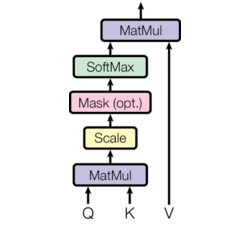
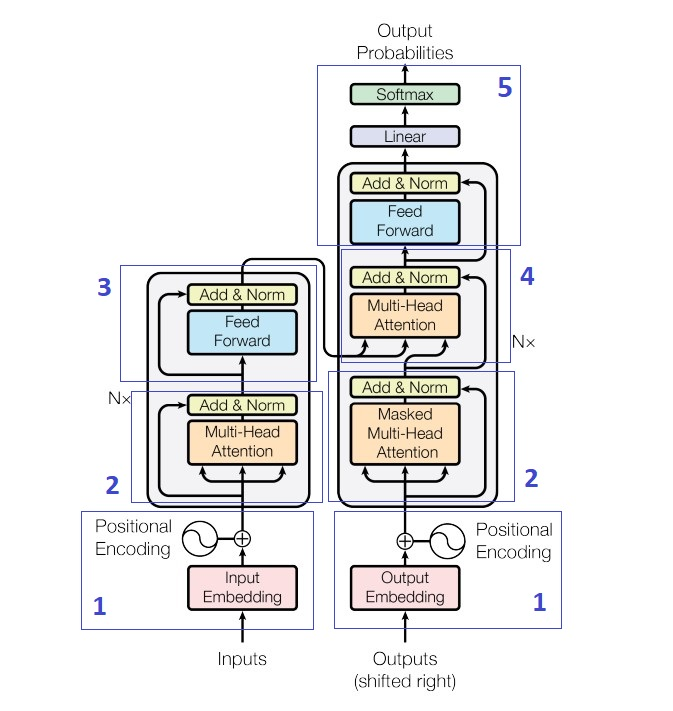
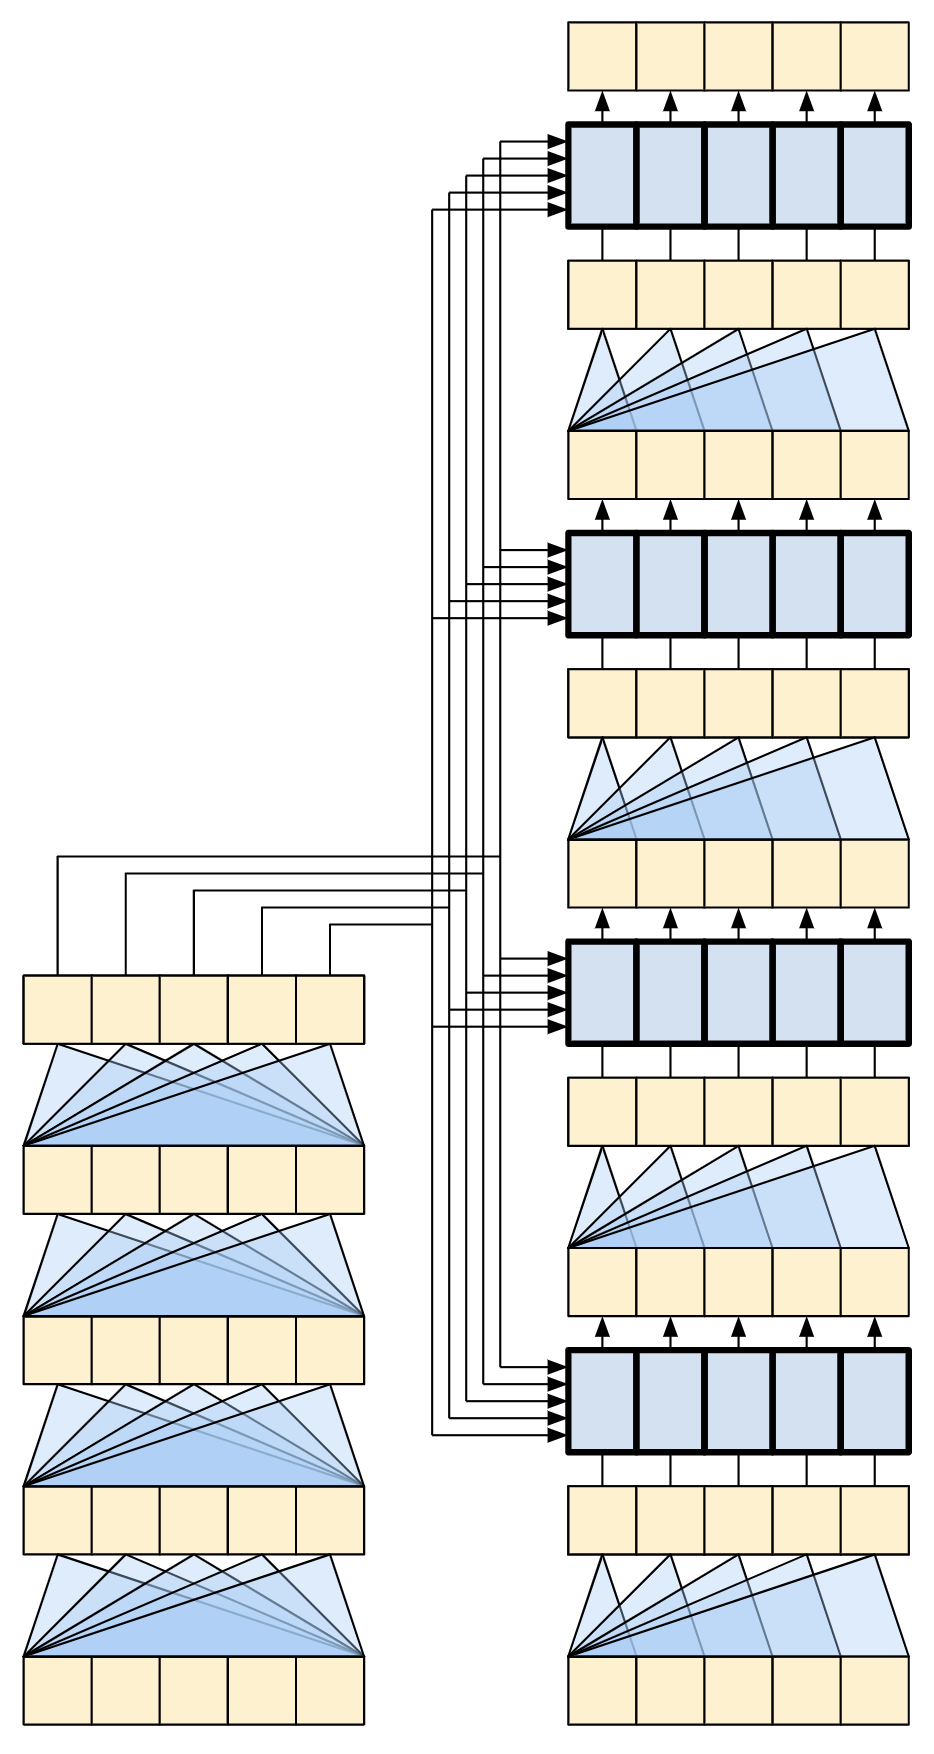
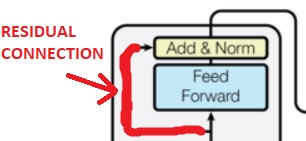

In [2]:
def postional_encoding(timesteps, d_model):
    # output of embedding layer is sized d_model x timesteps
    # let's create matrix that will be added to it
    positions = np.arange(timesteps)[:, np.newaxis] # [0, 1, ...] casted to shape timesteps x 1 
    depths = np.arange(0, d_model, 2)[np.newaxis, :]/d_model  # [0/d_model, 2/d_model, ...] casted to shape 1 x d_model/2
    angle_rates = positions / (10000 ** depths) # timesteps x d_model/2
    
    encoding = np.zeros((timesteps, d_model))
    encoding[:, 0::2] = np.sin(angle_rates)
    # if d_model is odd, cosine function will be used 1 time less than sine
    if d_model%2 == 0 :
        encoding[:, 1::2] = np.cos(angle_rates)
    else:
        encoding[:, 1::2] = np.cos(angle_rates)[:, :-1]
        
    
    return encoding

print(postional_encoding(2, 4))
# at timestep = 0
print([np.sin(0), np.cos(0), np.sin(0), np.cos(0)])
# at timestep = 1
print([np.sin(1/(10000**(0/4))), np.cos(1/(10000**(0/4))), np.sin(1/(10000**(2/4))), np.cos(1/(10000**(2/4)))])


[[0.         1.         0.         1.        ]
 [0.84147098 0.54030231 0.00999983 0.99995   ]]
[0.0, 1.0, 0.0, 1.0]
[0.8414709848078965, 0.5403023058681398, 0.009999833334166664, 0.9999500004166653]


Class below implements common part of encoder and decoder that processes inputs. It incorporates dense layer as embedding and positional encoding defined above.

In [3]:
class TransformerInput(tf.keras.layers.Layer):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Dense(d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x = x + postional_encoding(length, self.d_model)
    return x

#### Feed Forward layers
Implementation below follows Feed Forward layer's architecture from original Transformer paper, which is Dense layer with ReLu activation, followed by linear layer

In [4]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
    ])
    def call(self, x):
        return self.seq(x)


#### Residual connection and normalization
Implementation below is a wrapper that takes sublayer as input and outputs normalized result of adding input with sublayer's output.

In [5]:
class AddNormLayer(tf.keras.layers.Layer):
    def __init__(self, sublayer):
        # this class implements residual connection around sublayer
        # along with normalization layer
        super().__init__()
        self.sublayer = sublayer
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, *args):
        sublayer_output = self.sublayer(x, *args)
        x = self.add([x, sublayer_output])  # residual connection
        x = self.layernorm(x)
        return x

#### Encoder
Implementation is divided into 2 classes:
- EncoderLayer class that implements self-attention and feed forward network, both wrapped into residual connections with normalization layer
- Encoder class that stacks EncoderLayers on top of input layer consisting of embedding and positional encoding
![Encoder](./images/encoder.png)

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff):
    super().__init__()
    self.mha=tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    self.self_attention = lambda x: self.mha(query=x,value=x,key=x)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = AddNormLayer(self.self_attention)(x)
    x = AddNormLayer(self.ffn)(x)
    return x
  
class Encoder(tf.keras.layers.Layer):
  def __init__(self, n_layers, d_model, num_heads, dff):
    super().__init__()
    self.n_layers = n_layers
    self.input_layer = TransformerInput(d_model)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff) for _ in range(n_layers)]

  def call(self, x):
    x = self.input_layer(x)
    for i in range(self.n_layers):
        x = self.enc_layers[i](x)

    return x

#### Decoder
Implementation is divided into 2 classes:
- DecoderLayer class that implements masked self-attention, cross attention with encoder output as context and feed forward network, all wrapped into residual connections with normalization layer
- Decoder class that stacks DecoderLayer on top of input layer consisting of embedding and positional encoding
![Decoder](./images/decoder.png)

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff):
    super().__init__()
    self.mha=tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    self.self_attention = lambda x: self.mha(query=x,value=x,key=x, use_causal_mask = True)
    self.cross_attention = lambda x, context: self.mha(query=x,value=context,key=context)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = AddNormLayer(self.self_attention)(x)
    x = AddNormLayer(self.cross_attention)(x, context)
    x = AddNormLayer(self.ffn)(x)
    return x
  
class Decoder(tf.keras.layers.Layer):
  def __init__(self, n_layers, d_model, num_heads, dff):
    super().__init__()
    self.n_layers = n_layers
    self.input_layer = TransformerInput(d_model)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff) for _ in range(n_layers)]

  def call(self, x, context):
    x = self.input_layer(x)
    for i in range(self.n_layers):
        x = self.dec_layers[i](x, context)

    return x

#### Complete Transfomer

In [8]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, num_heads, dff, output_size):
        super().__init__()
        self.encoder = Encoder(n_layers, d_model, num_heads, dff)
        self.decoder = Decoder(n_layers, d_model, num_heads, dff)
        self.final_layer = tf.keras.layers.Dense(output_size)

    def call(self, data):
        encoder_inputs, decoder_inputs = data # decoder inputs are outputs shifted right
        context = self.encoder(encoder_inputs)
        x = self.decoder(decoder_inputs, context)
        x = self.final_layer(x)
        return x

In [11]:
n_layers = 4
d_model = 12
dff = 51
num_heads = 2
output_size = 1
input_size = 2

input_timesteps = 5
output_timesteps = 2
batch_size = 1
inputs = np.zeros((batch_size, input_timesteps, input_size))
# inputs = tf.convert_to_tensor(inputs)
outputs = np.zeros((batch_size, output_timesteps, output_size))
# outputs = tf.convert_to_tensor(outputs)

transformer = Transformer(n_layers, d_model, dff, num_heads, output_size)
x = transformer((inputs, outputs))
print(x.shape)
transformer.summary()

(1, 2, 1)
Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


ValueError: Weights for model 'sequential_16' have not yet been created. Weights are created when the model is first called on inputs or `build()` is called with an `input_shape`.